# Importing Libraries

In [11]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [12]:
os.listdir("data")

['.ipynb_checkpoints', 'Processed', 'raw']

In [13]:
os.listdir("data/processed")

['citibike_2022_with_weather.csv', '.ipynb_checkpoints']

In [14]:
#importing the dataset
df = pd.read_csv("data/Processed/citibike_2022_with_weather.csv")

#Making sure date is datetime
df["date"] = pd.to_datetime(df["started_at"]).dt.date  # if needed, recreate date field

# Keep only 2022 trips (not weather-filtered)
df_rides_2022 = df[df["date"].astype(str).str.startswith("2022")].copy()

df_rides_2022.head()

/var/folders/wf/s0crnzgd66b7pdj9_7_b6mpw0000gn/T/ipykernel_91997/599564648.py:2: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/Processed/citibike_2022_with_weather.csv")


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,date,avgTemp,_merge
0,3A2034DA67C8874B,electric_bike,2022-09-14 20:37:39.155,2022-09-14 21:05:39.760,N 12 St & Bedford Ave,5450.04,Albany St & Greenwich St,5145.02,40.720796,-73.954882,40.709267,-74.013247,casual,2022-09-14,22.9,both
1,F1C63DACDCC1C33D,electric_bike,2022-09-17 19:21:39.407,2022-09-17 20:08:32.670,Union Ave & Jackson St,5300.06,Metropolitan Ave & Meeker Ave,5300.05,40.716075,-73.952029,40.714133,-73.952344,casual,2022-09-17,20.8,both
2,94372C52777F4AC1,electric_bike,2022-09-17 16:49:21.830,2022-09-17 17:01:51.537,S 4 St & Wythe Ave,5204.05,St Marks Pl & 1 Ave,5626.13,40.712874,-73.965935,40.727791,-73.985649,casual,2022-09-17,20.8,both
3,44818FEC94B62B66,electric_bike,2022-09-08 12:27:40.019,2022-09-08 12:47:15.649,Amsterdam Ave & W 73 St,7260.09,Washington St & Gansevoort St,6039.06,40.779668,-73.980930,40.739323,-74.008119,casual,2022-09-08,21.8,both
4,F8A63709F214EBAA,classic_bike,2022-09-16 19:00:19.266,2022-09-16 19:07:28.905,University Pl & E 14 St,5905.14,Washington St & Gansevoort St,6039.06,40.734814,-73.992085,40.739323,-74.008119,member,2022-09-16,19.6,both


In [15]:
#Double Checking columns
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'date', 'avgTemp', '_merge'],
      dtype='object')

# Weather-only dataframe & time series

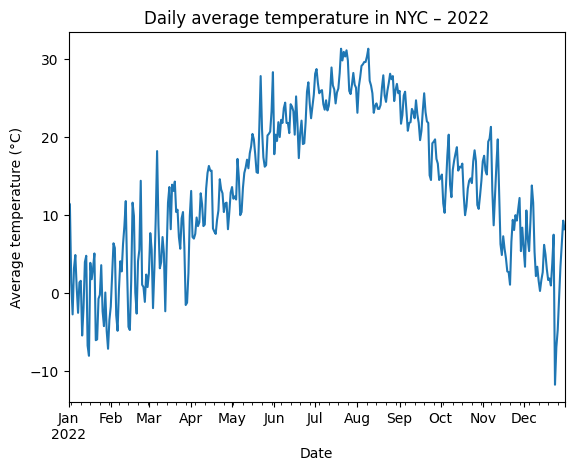

In [18]:
#Filtering
df_2022 = df[(df["avgTemp"].notna()) & (df["date"].dt.year == 2022)].copy()

#Creating a weather-only dataframe
weather_df = df_2022[["date", "avgTemp"]].drop_duplicates().copy()

#Setting date as index for time series
weather_df = weather_df.set_index("date").sort_index()

#Simple pandas plot
weather_df["avgTemp"].plot()

plt.title("Daily average temperature in NYC – 2022")
plt.xlabel("Date")
plt.ylabel("Average temperature (°C)")
plt.show()

In [9]:
#Group by date for TRUE total daily rides
trips_per_day = (
    df_rides_2022.groupby("date")["ride_id"]
                 .count()
                 .reset_index(name="bike_rides_daily"))
trips_per_day["date"] = pd.to_datetime(trips_per_day["date"])
trips_per_day.head()

,date,bike_rides_daily
0,2022-01-01,522
1,2022-01-02,1089
2,2022-01-03,880
3,2022-01-04,907
4,2022-01-05,819


In [31]:
#Merging trips per day with weather dataframe

#Starting from the weather-only dataframe (date is currently the index)
weather_for_merge = weather_df.reset_index()  # bring 'date' back as a column

#Merging daily trip counts into the weather dataframe
df_temp = weather_for_merge.merge(trips_per_day, on="date", how="left")

#Setting date back as index for plotting and sort by date
df_temp = df_temp.set_index("date").sort_index()

df_temp.head()

,avgTemp,bike_rides_daily
date,,
2022-01-01,11.6,522
2022-01-02,11.4,1089
2022-01-03,1.4,880
2022-01-04,-2.7,907
2022-01-05,3.2,819


# Dual Axis Line chart

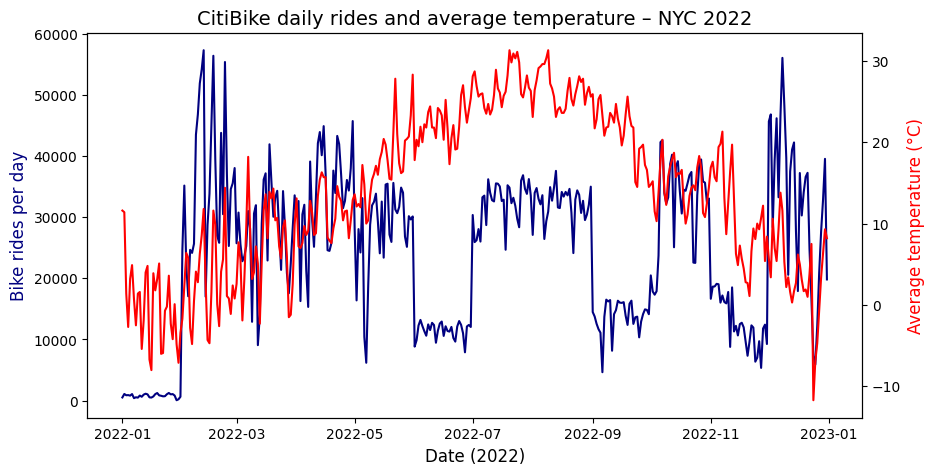

In [32]:
#Creating figure and first axis object
fig, ax = plt.subplots(figsize=(10, 5))

#Plotting bike rides on the first y-axis
ax.plot(df_temp.index, df_temp["bike_rides_daily"], color="navy")
ax.set_xlabel("Date (2022)", fontsize=12)
ax.set_ylabel("Bike rides per day", color="navy", fontsize=12)

#Creating the twin axis for temperature
ax2 = ax.twinx()
ax2.plot(df_temp.index, df_temp["avgTemp"], color="red")
ax2.set_ylabel("Average temperature (°C)", color="red", fontsize=12)

#Title
plt.title("CitiBike daily rides and average temperature – NYC 2022", fontsize=14)

plt.show()